In [56]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0-rc1


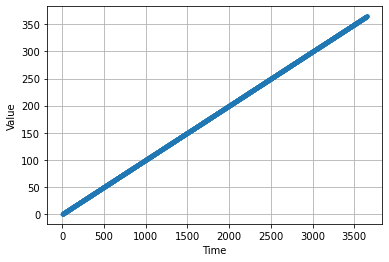

In [74]:
def plot_series(time,series,format='.',start=0,end=None):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)  

def trend(time,slope=1):
  return time*slope


def seasonal_pattern(season_time):

    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):

    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3 
plot_series(time,series) 


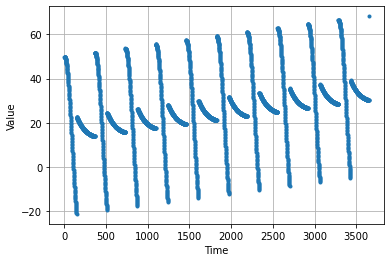

In [75]:
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
plot_series(time,series)



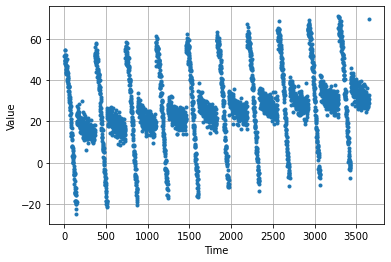

In [76]:
series+= noise(time, noise_level, seed=42)
plot_series(time,series)

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def make_dataset(series,window_size,batch_size,shuffle_buffer):
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset=dataset.flat_map(lambda window:window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
dataset=make_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

In [80]:
#using RNN
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
94/94 [==============================] - 1s 9ms/step - loss: 14.1760 - mae: 14.7455
Epoch 2/400
94/94 [==============================] - 1s 9ms/step - loss: 8.0297 - mae: 8.5703
Epoch 3/400
94/94 [==============================] - 1s 9ms/step - loss: 8.5738 - mae: 9.0846
Epoch 4/400
94/94 [==============================] - 1s 9ms/step - loss: 7.8754 - mae: 8.3993
Epoch 5/400
94/94 [==============================] - 1s 9ms/step - loss: 7.0045 - mae: 7.5020
Epoch 6/400
94/94 [==============================] - 1s 9ms/step - loss: 5.5845 - mae: 6.0105
Epoch 7/400
94/94 [==============================] - 1s 8ms/step - loss: 5.6128 - mae: 6.0647
Epoch 8/400
94/94 [==============================] - 1s 9ms/step - loss: 4.7263 - mae: 5.1971
Epoch 9/400
94/94 [==============================] - 1s 9ms/step - loss: 6.3388 - mae: 6.7731
Epoch 10/400
94/94 [==============================] - 1s 9ms/step - loss: 6.2465 - mae: 6.7477
Epoch 11/400
94/94 [==============================] - 1s 

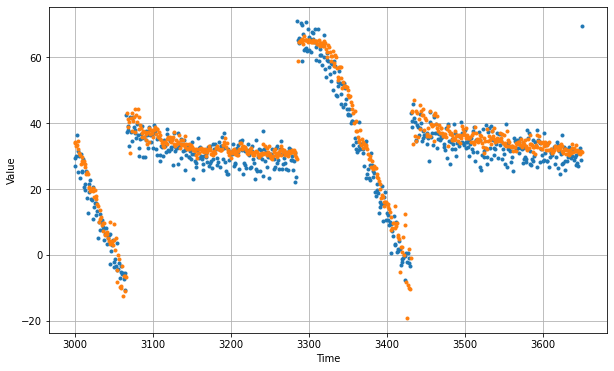

In [81]:
forecast=[]
results=[]
for time in range(len(series)-window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))
forecast=forecast[split_time-window_size:]
results=np.array(forecast)[:, 0, 0]
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results) 

In [82]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()


3.8447824

In [83]:
#Using LSTM and varying learning rate of stochastic gradient descent 
model=tf.keras.Sequential([
                           tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=-1),input_shape=[None]),
                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                           tf.keras.layers.Dense(1),
                           tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr=tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8*10**(epoch/20)
)
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr])

Epoch 1/100
94/94 [==============================] - 3s 28ms/step - loss: 57.3816 - mae: 57.8862 - lr: 1.0000e-08
Epoch 2/100
94/94 [==============================] - 3s 28ms/step - loss: 55.2792 - mae: 55.7048 - lr: 1.1220e-08
Epoch 3/100
94/94 [==============================] - 3s 27ms/step - loss: 52.6630 - mae: 53.1155 - lr: 1.2589e-08
Epoch 4/100
94/94 [==============================] - 3s 28ms/step - loss: 49.5514 - mae: 50.0174 - lr: 1.4125e-08
Epoch 5/100
94/94 [==============================] - 3s 28ms/step - loss: 45.8181 - mae: 46.2713 - lr: 1.5849e-08
Epoch 6/100
94/94 [==============================] - 3s 28ms/step - loss: 41.2551 - mae: 41.8043 - lr: 1.7783e-08
Epoch 7/100
94/94 [==============================] - 3s 28ms/step - loss: 36.2971 - mae: 36.7661 - lr: 1.9953e-08
Epoch 8/100
94/94 [==============================] - 3s 27ms/step - loss: 30.7113 - mae: 31.3439 - lr: 2.2387e-08
Epoch 9/100
94/94 [==============================] - 3s 28ms/step - loss: 24.9775 - mae:

(1e-08, 0.0001, 0.0, 30.0)

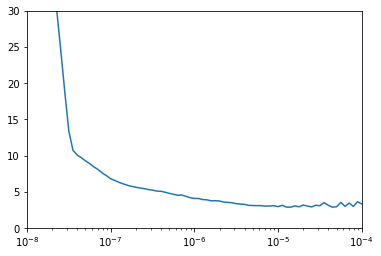

In [84]:
#plot of learning rate vs loss of every epoch
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

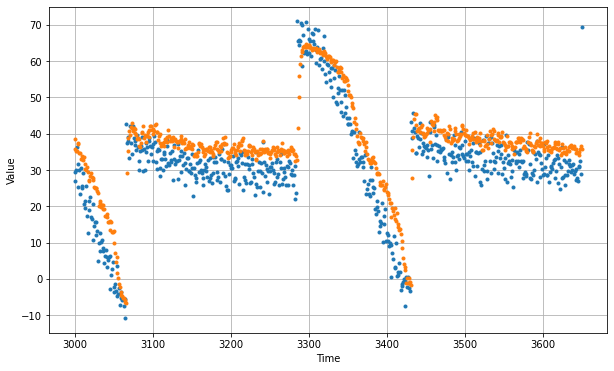

In [85]:
forecast=[]
results=[]
for time in range(len(series)-window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))
forecast=forecast[split_time-window_size:]
results=np.array(forecast)[:, 0, 0]
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results) 

In [86]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.430282

<Figure size 432x288 with 0 Axes>

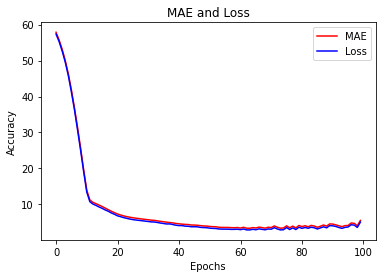

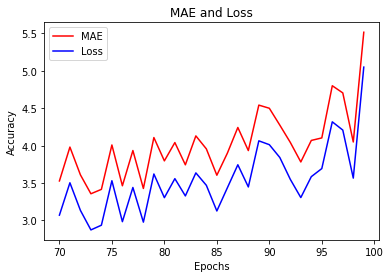

<Figure size 432x288 with 0 Axes>

In [87]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss))

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[70:]
mae_zoom = mae[70:]
loss_zoom = loss[70:]


plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [0]:
dataset = make_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

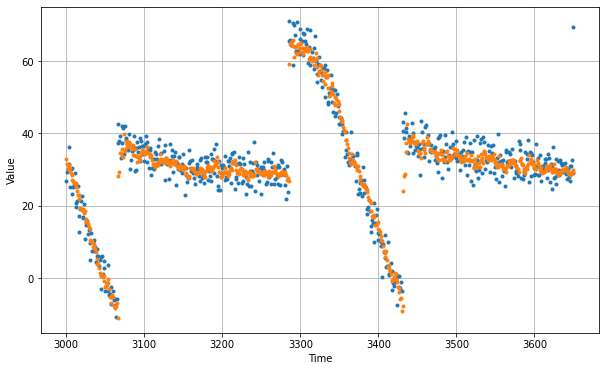

In [89]:
forecast=[]
for time in range(len(series) - window_size):
  
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [90]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.2015667

<Figure size 432x288 with 0 Axes>

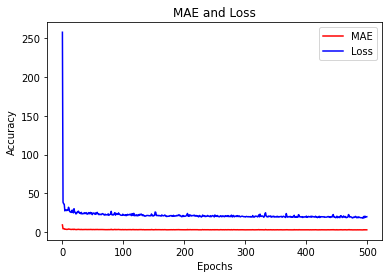

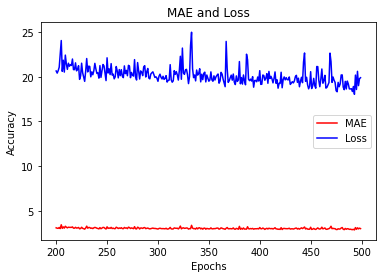

<Figure size 432x288 with 0 Axes>

In [91]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss))


plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()